In [7]:
# --- CONFIG: EDIT THESE PATHS ---
from pathlib import Path

# Source (your existing D1 folder with TIFFs + JSONs)
SRC_DIR = Path("/Users/thabangisaka/Downloads/thabang_personal/Processed Datasets/Dataset - Originals and Year 2 Experiments/PlasmoCount Automated detection and staging of malaria parasites from cytological smears using convolutional neural networks")

# Destination (cleaned D1 in unified schema)
DST_DIR = Path("/Users/thabangisaka/Downloads/thabang_personal/Year 3 Experiments/malaria_experiments/D1_davidson")

# Split ratios
VAL_RATIO = 0.15
RANDOM_SEED = 42

# JPEG save params
JPEG_QUALITY = 95

# Dry-run (True = parse everything, build JSONs, BUT do not copy/convert images)
DRY_RUN = False

# --- IMPORTS ---
import json, math, shutil, hashlib, warnings, random
from collections import defaultdict, Counter
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional

import numpy as np
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split

print("SRC_DIR:", SRC_DIR)
print("DST_DIR:", DST_DIR)


SRC_DIR: /Users/thabangisaka/Downloads/thabang_personal/Processed Datasets/Dataset - Originals and Year 2 Experiments/PlasmoCount Automated detection and staging of malaria parasites from cytological smears using convolutional neural networks
DST_DIR: /Users/thabangisaka/Downloads/thabang_personal/Year 3 Experiments/malaria_experiments/D1_davidson


In [20]:
# ---------- IO ----------
def read_json(p: Path):
    with open(p, "r") as f:
        return json.load(f)

def write_json(obj, p: Path):
    p.parent.mkdir(parents=True, exist_ok=True)
    with open(p, "w") as f:
        json.dump(obj, f, indent=2)

def md5(s: str) -> str:
    return hashlib.md5(s.encode("utf-8")).hexdigest()

# ---------- BBOX ----------
def xywh_from_rcminmax(min_r, min_c, max_r, max_c):
    # Incoming JSON uses r=row=y, c=col=x
    x, y = int(min_c), int(min_r)
    w, h = int(max_c - min_c), int(max_r - min_r)
    return [x, y, w, h]

def iou_xywh(a, b):
    ax, ay, aw, ah = a
    bx, by, bw, bh = b
    ax2, ay2 = ax + aw, ay + ah
    bx2, by2 = bx + bw, by + bh
    inter_x1, inter_y1 = max(ax, bx), max(ay, by)
    inter_x2, inter_y2 = min(ax2, bx2), min(ay2, by2)
    iw, ih = max(0, inter_x2 - inter_x1), max(0, inter_y2 - inter_y1)
    inter = iw * ih
    if inter == 0:
        return 0.0
    union = aw*ah + bw*bh - inter
    return inter / union if union > 0 else 0.0

# ---------- STAGE MAPPING ----------
# Map fine labels to macro stage
FINE_TO_MACRO = {
    "early_ring": "ring", "late_ring": "ring",
    "early_trophozoite": "trophozoite", "late_trophozoite": "trophozoite",
    "early_schizont": "schizont", "late_schizont": "schizont",
    "gametocyte": "gametocyte",
    "multiple_infections": None,
    "not_sure": None,
    "not_a_cell_(e.g._debris,_merozoites,_etc.)": None
}
MACRO_ENUM = ["ring", "trophozoite", "schizont", "gametocyte", "none"]

def macro_vote_from_lists(list_of_label_lists: List[List[str]]) -> Tuple[str, str]:
    """
    list_of_label_lists: e.g. [["early_ring"], ["late_ring"], ["late_ring","early_ring"]]
    Returns (macro_stage, quality) where macro_stage in MACRO_ENUM and quality in {"high","low"}
    Rule:
      - Map fine labels -> macro
      - Count votes over macros (ignore None)
      - If clear majority -> that macro, quality=high
      - If tie / only None / only multiple_infections -> macro="none", quality="low"
    """
    votes = []
    saw_uncertain = False
    for labels in list_of_label_lists:
        if isinstance(labels, str):
            labels = [labels]
        mapped = []
        for lab in labels:
            m = FINE_TO_MACRO.get(lab, None)
            if m is None:
                saw_uncertain = True
            else:
                mapped.append(m)
        votes.extend(mapped)
    if not votes:
        return "none", "low"
    c = Counter(votes)
    top, n_top = c.most_common(1)[0]
    # Check tie
    n_second = 0
    if len(c) > 1:
        n_second = c.most_common(2)[1][1]
    if n_second == n_top:
        return "none", "low"
    # Otherwise majority
    return top, ("low" if saw_uncertain else "high")

# ---------- LOG ----------
def log_stats(title, d):
    print(f"\n--- {title} ---")
    for k, v in d.items():
        print(f"{k:30s}: {v}")


In [9]:
train_boxes = read_json(SRC_DIR / "training.json")
test_boxes  = read_json(SRC_DIR / "test.json")
train_stg   = read_json(SRC_DIR / "training_stages.json")
test_stg    = read_json(SRC_DIR / "test_stages.json")

print("Samples:")
print(" training.json:", len(train_boxes), "images")
print(" training_stages.json:", len(train_stg), "images")
print(" test.json:", len(test_boxes), "images")
print(" test_stages.json:", len(test_stg), "images")


Samples:
 training.json: 283 images
 training_stages.json: 218 images
 test.json: 121 images
 test_stages.json: 121 images


In [10]:
@dataclass
class DetBox:
    bbox: List[int]  # xywh
    category: str    # "infected" | "uninfected"
    ann_id: str

def parse_boxes(obj_list):
    by_image = defaultdict(list)
    for entry in obj_list:
        img = entry["image"]["pathname"]
        for obj in entry["objects"]:
            mn = obj["bounding_box"]["minimum"]
            mx = obj["bounding_box"]["maximum"]
            xywh = xywh_from_rcminmax(mn["r"], mn["c"], mx["r"], mx["c"])
            cat = obj["category"]
            # train/test boxes here are strings
            assert isinstance(cat, str), f"Unexpected category type: {type(cat)}"
            # Make a stable ann_id from filename + bbox coords
            ann = f"{img}|{xywh[0]},{xywh[1]},{xywh[2]},{xywh[3]}|{cat}"
            ann_id = md5(ann)[:12]
            by_image[img].append(DetBox(xywh, cat, ann_id))
    return by_image

train_by_img = parse_boxes(train_boxes)
test_by_img  = parse_boxes(test_boxes)

log_stats("Counts (infected/uninfected)", {
    "train images": len(train_by_img),
    "test images": len(test_by_img),
    "train boxes": sum(len(v) for v in train_by_img.values()),
    "test boxes": sum(len(v) for v in test_by_img.values()),
})



--- Counts (infected/uninfected) ---
train images                  : 283
test images                   : 121
train boxes                   : 28460
test boxes                    : 9067


In [11]:
@dataclass
class StageBox:
    bbox: List[int]
    votes: List[List[str]]  # multi-annotator label lists

def parse_stage_boxes(stage_list):
    by_image = defaultdict(list)
    for entry in stage_list:
        img = entry["image"]["pathname"]
        for obj in entry["objects"]:
            mn = obj["bounding_box"]["minimum"]
            mx = obj["bounding_box"]["maximum"]
            xywh = xywh_from_rcminmax(mn["r"], mn["c"], mx["r"], mx["c"])
            cats = obj["category"]
            by_image[img].append(StageBox(xywh, cats))
    return by_image

train_stg_by_img = parse_stage_boxes(train_stg)
test_stg_by_img  = parse_stage_boxes(test_stg)

# Match: for each infected box, find best stage box by IoU>=0.5
def attach_stages(rbc_by_img, stg_by_img):
    matched = 0
    stage_missing = 0
    stage_ties = 0
    out_stage_attrs = {}  # (img, ann_id) -> (macro_stage, quality)
    for img, boxes in rbc_by_img.items():
        stg = stg_by_img.get(img, [])
        for rb in boxes:
            if rb.category != "infected":
                continue
            best_iou, best_idx = 0.0, -1
            for i, sb in enumerate(stg):
                iou = iou_xywh(rb.bbox, sb.bbox)
                if iou > best_iou:
                    best_iou, best_idx = iou, i
            if best_iou >= 0.5 and best_idx >= 0:
                macro, q = macro_vote_from_lists(stg[best_idx].votes)
                out_stage_attrs[(img, rb.ann_id)] = (macro, q)
                matched += 1
            else:
                out_stage_attrs[(img, rb.ann_id)] = ("none", "low")
                stage_missing += 1
    log_stats("Stage matching", {
        "infected boxes total": sum(1 for v in rbc_by_img.values() for b in v if b.category=="infected"),
        "matched": matched,
        "no stage found (IoU<0.5)": stage_missing,
    })
    return out_stage_attrs

train_stage_attrs = attach_stages(train_by_img, train_stg_by_img)
test_stage_attrs  = attach_stages(test_by_img,  test_stg_by_img)



--- Stage matching ---
infected boxes total          : 1991
matched                       : 1201
no stage found (IoU<0.5)      : 790

--- Stage matching ---
infected boxes total          : 410
matched                       : 410
no stage found (IoU<0.5)      : 0


In [12]:
# Collect all image names and sizes; detect corrupts
from PIL import ImageStat

def pil_size(path):
    with Image.open(path) as im:
        im.load()
        return im.size  # (w,h)

all_imgs = sorted(set(list(train_by_img.keys()) + list(test_by_img.keys())))
print("Total unique images referenced:", len(all_imgs))

src_images = {name: SRC_DIR / name for name in all_imgs}

img_sizes = {}
corrupt = []
for name, p in src_images.items():
    try:
        sz = pil_size(p)
        img_sizes[name] = sz
    except (UnidentifiedImageError, FileNotFoundError, OSError) as e:
        warnings.warn(f"Corrupt/missing: {name} ({e})")
        corrupt.append(name)

print("OK images:", len(img_sizes))
print("Corrupt/missing:", len(corrupt))
if corrupt:
    print("Example corrupt:", corrupt[:5])

# Drop annotations for corrupt images
for name in corrupt:
    train_by_img.pop(name, None)
    test_by_img.pop(name, None)
    train_stage_attrs = {k:v for k,v in train_stage_attrs.items() if k[0]!=name}
    test_stage_attrs  = {k:v for k,v in test_stage_attrs.items() if k[0]!=name}

# Prepare train/val split (from train images only)
train_img_names = sorted(train_by_img.keys())
# Stratify by infected count per image (bucketized)
def infected_count(img_name, by_img_dict):
    return sum(1 for b in by_img_dict[img_name] if b.category=="infected")

infected_counts = np.array([infected_count(n, train_by_img) for n in train_img_names])
# Bin counts: 0, 1, 2-3, 4-6, 7+
bins = np.digitize(infected_counts, bins=[0,1,3,6], right=True)
X = np.arange(len(train_img_names))
train_idx, val_idx = train_test_split(X, test_size=VAL_RATIO, random_state=RANDOM_SEED, stratify=bins)
val_img_names   = [train_img_names[i] for i in val_idx]
train_img_names = [train_img_names[i] for i in train_idx]

log_stats("Split (images)", {
    "train": len(train_img_names),
    "val": len(val_img_names),
    "test": len(test_by_img),
})


Total unique images referenced: 404


/var/folders/q2/_5xt7c4d1nn0n9q5xb4mw5ch0000gn/T/ipykernel_88964/4134773873.py:21: UserWarning: Corrupt/missing: 0b1cb0e7-281e-4981-b5a4-e6ebb004bd70.tif ([Errno 2] No such file or directory: '/Users/thabangisaka/Downloads/thabang_personal/Processed Datasets/Dataset - Originals and Year 2 Experiments/PlasmoCount Automated detection and staging of malaria parasites from cytological smears using convolutional neural networks/0b1cb0e7-281e-4981-b5a4-e6ebb004bd70.tif')
  warnings.warn(f"Corrupt/missing: {name} ({e})")
/var/folders/q2/_5xt7c4d1nn0n9q5xb4mw5ch0000gn/T/ipykernel_88964/4134773873.py:21: UserWarning: Corrupt/missing: 3e1f4f04-01f4-4ea0-be9f-f30ceb4557cf.tif ([Errno 2] No such file or directory: '/Users/thabangisaka/Downloads/thabang_personal/Processed Datasets/Dataset - Originals and Year 2 Experiments/PlasmoCount Automated detection and staging of malaria parasites from cytological smears using convolutional neural networks/3e1f4f04-01f4-4ea0-be9f-f30ceb4557cf.tif')
  warnings

OK images: 398
Corrupt/missing: 6
Example corrupt: ['0b1cb0e7-281e-4981-b5a4-e6ebb004bd70.tif', '3e1f4f04-01f4-4ea0-be9f-f30ceb4557cf.tif', '5a745ec3-78c8-4049-980e-19401e0bdfe1.tif', 'c9069f01-13d3-4302-9d46-2ffdae49c9a0.tif', 'd6016ea2-4ba5-4fb4-b78c-80d153b6bb02.tif']

--- Split (images) ---
train                         : 239
val                           : 43
test                          : 116


In [13]:
# COCO IDs
CAT_RBC = 1
CATEGORIES = [{"id": CAT_RBC, "name": "RBC"}]  # (Optional later: add WBC/platelet if present)

def build_coco_and_sidecar(split_img_names, by_img_dict, stage_attrs, species_for_infected="falciparum"):
    images = []
    annotations = []
    sidecar = defaultdict(dict)

    imgid_map = {}
    ann_id_auto = 1

    for i_name in split_img_names:
        if i_name not in img_sizes:
            # already filtered corrupt
            continue
        w, h = img_sizes[i_name]
        iid = len(images) + 1
        imgid_map[i_name] = iid
        images.append({"id": iid, "file_name": Path(i_name).name.replace(".tif",".jpg"), "width": w, "height": h})

        for rb in by_img_dict[i_name]:
            xywh = rb.bbox
            ann = {
                "id": ann_id_auto,
                "image_id": iid,
                "category_id": CAT_RBC,
                "bbox": xywh,
                "area": xywh[2]*xywh[3],
                "iscrowd": 0
            }
            annotations.append(ann)

            # Sidecar attributes (RBC only)
            infected = 1 if rb.category=="infected" else 0
            if infected == 1:
                # Stage from matched stages
                macro, q = stage_attrs.get((i_name, rb.ann_id), ("none","low"))
                species = species_for_infected  # D1 is Pf
            else:
                macro, q = ("none", "high")
                species = "none"
            sidecar[Path(i_name).name.replace(".tif",".jpg")][str(ann_id_auto)] = {
                "infected": infected,
                "species": species,
                "stage": macro,
                "quality": q
            }
            ann_id_auto += 1

    coco = {
        "images": images,
        "annotations": annotations,
        "categories": CATEGORIES
    }
    return coco, sidecar

# Build three splits
COCO_train, SC_train = build_coco_and_sidecar(train_img_names, train_by_img, train_stage_attrs)
COCO_val,   SC_val   = build_coco_and_sidecar(val_img_names,   train_by_img, train_stage_attrs)
COCO_test,  SC_test  = build_coco_and_sidecar(sorted(test_by_img.keys()),    test_by_img,  test_stage_attrs)

log_stats("COCO sizes", {
    "train images": len(COCO_train["images"]),
    "train ann": len(COCO_train["annotations"]),
    "val images": len(COCO_val["images"]),
    "val ann": len(COCO_val["annotations"]),
    "test images": len(COCO_test["images"]),
    "test ann": len(COCO_test["annotations"]),
})



--- COCO sizes ---
train images                  : 239
train ann                     : 24544
val images                    : 43
val ann                       : 3796
test images                   : 116
test ann                      : 8713


In [14]:
# Make folders
(IM_TRAIN := (DST_DIR/"images/train")).mkdir(parents=True, exist_ok=True)
(IM_VAL   := (DST_DIR/"images/val")).mkdir(parents=True, exist_ok=True)
(IM_TEST  := (DST_DIR/"images/test")).mkdir(parents=True, exist_ok=True)
(ANNO_DIR := (DST_DIR/"annotations")).mkdir(parents=True, exist_ok=True)
(META_DIR := (DST_DIR/"meta")).mkdir(parents=True, exist_ok=True)

# Write JSONs
write_json(COCO_train, ANNO_DIR/"coco_train.json")
write_json(SC_train,   ANNO_DIR/"sidecar_train.json")
write_json(COCO_val,   ANNO_DIR/"coco_val.json")
write_json(SC_val,     ANNO_DIR/"sidecar_val.json")
write_json(COCO_test,  ANNO_DIR/"coco_test.json")
write_json(SC_test,    ANNO_DIR/"sidecar_test.json")

print("Wrote COCO + sidecars to:", ANNO_DIR)

# Convert .tif -> .jpg and place in split folders
def convert_and_copy(split_img_names, dest_dir):
    copied, skipped = 0, 0
    for i_name in split_img_names:
        src = SRC_DIR / i_name
        dst = dest_dir / Path(i_name).name.replace(".tif",".jpg")
        if DRY_RUN:
            copied += 1
            continue
        try:
            with Image.open(src) as im:
                im = im.convert("RGB")
                im.save(dst, format="JPEG", quality=JPEG_QUALITY, optimize=True)
            copied += 1
        except Exception as e:
            warnings.warn(f"Failed image copy/convert: {i_name} ({e})")
            skipped += 1
    return copied, skipped

copied_t, skipped_t = convert_and_copy(train_img_names, IM_TRAIN)
copied_v, skipped_v = convert_and_copy(val_img_names, IM_VAL)
copied_e, skipped_e = convert_and_copy(sorted(test_by_img.keys()), IM_TEST)

log_stats("Image copy/convert", {
    "train copied": copied_t, "train skipped": skipped_t,
    "val copied": copied_v,   "val skipped": skipped_v,
    "test copied": copied_e,  "test skipped": skipped_e,
})


Wrote COCO + sidecars to: /Users/thabangisaka/Downloads/thabang_personal/Year 3 Experiments/malaria_experiments/D1_davidson/annotations

--- Image copy/convert ---
train copied                  : 239
train skipped                 : 0
val copied                    : 43
val skipped                   : 0
test copied                   : 116
test skipped                  : 0


In [15]:
import csv

# Enums
classes_species = ["falciparum","vivax","malariae","ovale","knowlesi","none"]
classes_stage   = ["ring","trophozoite","schizont","gametocyte","none"]

write_json(classes_species, META_DIR/"classes_species.json")
write_json(classes_stage,   META_DIR/"classes_stage.json")

# Compute α (inverse-frequency, smoothed) from TRAIN ONLY
def count_attr(sidecar, key, exclude_none=True):
    c = Counter()
    for fname, d in sidecar.items():
        for annid, attr in d.items():
            val = attr.get(key, "none")
            if exclude_none and val == "none":
                continue
            c[val] += 1
    return c

sp_counts = count_attr(SC_train, "species")  # Pf should dominate
st_counts = count_attr(SC_train, "stage")

def invfreq_alpha(all_classes, counts):
    eps = 1.0
    weights = []
    for c in all_classes:
        if c == "none":
            continue  # we don't train on 'none'
        w = 1.0 / (counts.get(c,0) + eps)
        weights.append(w)
    s = sum(weights)
    weights = [w/s for w in weights]
    return {c:w for c,w in zip([c for c in all_classes if c!="none"], weights)}

alpha_species = invfreq_alpha(classes_species, sp_counts)
alpha_stage   = invfreq_alpha(classes_stage,   st_counts)

write_json(alpha_species, META_DIR/"class_weights_species.json")
write_json(alpha_stage,   META_DIR/"class_weights_stage.json")

# Transforms info (placeholder: you can fill stain/scale once you decide)
transforms = {
    "stain_normalization": "pending (e.g., macenko_v1)",
    "scale_px_per_rbc_target": "pending (e.g., ~70 px)"
}
write_json(transforms, META_DIR/"transforms.json")

# Split index
with open(META_DIR/"split_index.csv","w",newline="") as f:
    w = csv.writer(f)
    w.writerow(["image_name","split"])
    for n in train_img_names: w.writerow([Path(n).name.replace(".tif",".jpg"), "train"])
    for n in val_img_names:   w.writerow([Path(n).name.replace(".tif",".jpg"), "val"])
    for n in sorted(test_by_img.keys()): w.writerow([Path(n).name.replace(".tif",".jpg"), "test"])

# Audit CSV (one row per annotation)
with open(META_DIR/"audit_master.csv","w",newline="") as f:
    w = csv.writer(f)
    w.writerow(["image_name","ann_id","x","y","w","h","infected","species","stage","quality","split"])
    def dump(coco, sc, split):
        # map image_id -> file_name
        id2name = {im["id"]: im["file_name"] for im in coco["images"]}
        for ann in coco["annotations"]:
            img_name = id2name[ann["image_id"]]
            ann_id = str(ann["id"])
            attrs = sc[img_name][ann_id]
            x,y,w_,h_ = ann["bbox"]
            w.writerow([img_name, ann_id, x,y,w_,h_, attrs["infected"], attrs["species"], attrs["stage"], attrs["quality"], split])
    dump(COCO_train, SC_train, "train")
    dump(COCO_val,   SC_val,   "val")
    dump(COCO_test,  SC_test,  "test")

print("Wrote meta files to:", META_DIR)
print("Alpha species:", alpha_species)
print("Alpha stage:", alpha_stage)


Wrote meta files to: /Users/thabangisaka/Downloads/thabang_personal/Year 3 Experiments/malaria_experiments/D1_davidson/meta
Alpha species: {'falciparum': 0.00014003640946646127, 'vivax': 0.24996499089763338, 'malariae': 0.24996499089763338, 'ovale': 0.24996499089763338, 'knowlesi': 0.24996499089763338}
Alpha stage: {'ring': 0.00197544858404518, 'trophozoite': 0.002795761979114789, 'schizont': 0.005529048830204667, 'gametocyte': 0.9896997406066353}


In [18]:
import math, random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch

def show_examples_grid(coco, sidecar, img_dir, k=12, ncols=4, seed=0,
                       draw_text=True, draw_boxes=True, lw=1.5):
    """
    Compact grid viewer:
      - infected = RED boxes
      - uninfected = GREEN boxes
      - title shows image name + counts
      - legend once at the bottom
    """
    rng = random.Random(seed)
    id2name = {im["id"]: im["file_name"] for im in coco["images"]}
    anns_by_imgid = defaultdict(list)
    for ann in coco["annotations"]:
        anns_by_imgid[ann["image_id"]].append(ann)
    img_ids = list(id2name.keys())
    if not img_ids:
        print("No images to display.")
        return
    rng.shuffle(img_ids)
    img_ids = img_ids[:min(k, len(img_ids))]

    nrows = math.ceil(len(img_ids) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.2*ncols, 4.2*nrows))
    if nrows == 1 and ncols == 1:
        axes = [[axes]]
    elif nrows == 1:
        axes = [axes]
    elif ncols == 1:
        axes = [[ax] for ax in axes]

    infected_patch = Patch(edgecolor='red', facecolor='none', label='Infected (red)')
    uninfected_patch = Patch(edgecolor='green', facecolor='none', label='Uninfected (green)')

    for idx, iid in enumerate(img_ids):
        r = idx // ncols
        c = idx % ncols
        ax = axes[r][c]
        name = id2name[iid]
        path = img_dir / name
        if not path.exists():
            ax.set_axis_off()
            ax.set_title(f"{name} (missing)")
            continue

        with Image.open(path) as im:
            ax.imshow(im)

        anns = anns_by_imgid.get(iid, [])
        inf_cnt = 0
        un_cnt = 0
        for ann in anns:
            x,y,w,h = ann["bbox"]
            attrs = sidecar[name][str(ann["id"])]
            is_inf = bool(attrs["infected"])
            if is_inf:
                color = 'red'; inf_cnt += 1
            else:
                color = 'green'; un_cnt += 1

            if draw_boxes:
                rect = patches.Rectangle((x,y), w,h, linewidth=lw, edgecolor=color, facecolor='none')
                ax.add_patch(rect)

            if draw_text:
                # shorter text; only print for infected to reduce clutter
                if is_inf:
                    sp = attrs.get("species","")
                    st = attrs.get("stage","")
                    txt = f"{sp}:{st}" if st != "none" else f"{sp}"
                    ax.text(x, max(0,y-2), txt, fontsize=7, color='white',
                            bbox=dict(facecolor='black', alpha=0.35, pad=1))

        ax.set_title(f"{name}\nINF={inf_cnt}  UN={un_cnt}", fontsize=9)
        ax.axis('off')

    # Hide any empty axes
    for idx in range(len(img_ids), nrows*ncols):
        r = idx // ncols; c = idx % ncols
        axes[r][c].set_axis_off()

    # One legend under the grid
    handles = [infected_patch, uninfected_patch]
    fig.legend(handles=handles, loc='lower center', ncol=2, frameon=False)
    plt.tight_layout(rect=[0,0.05,1,1])
    plt.show()


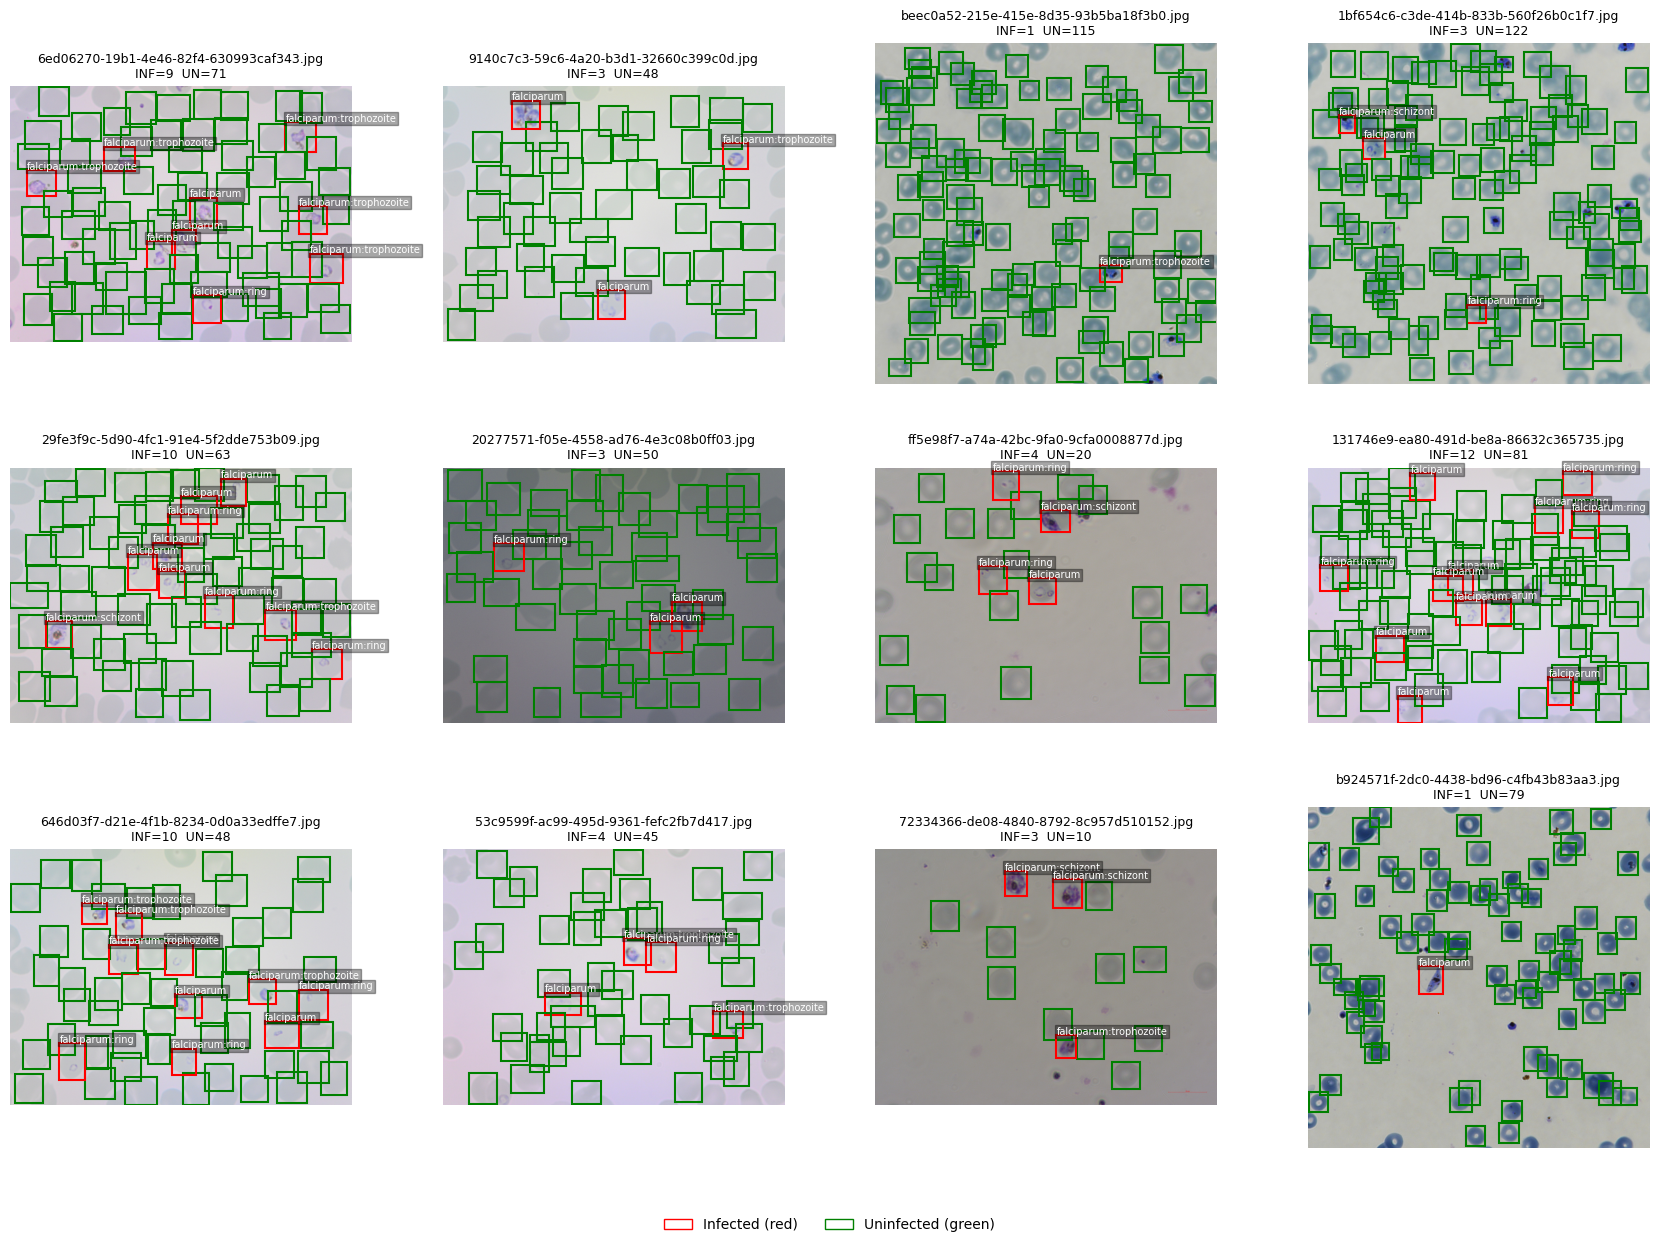

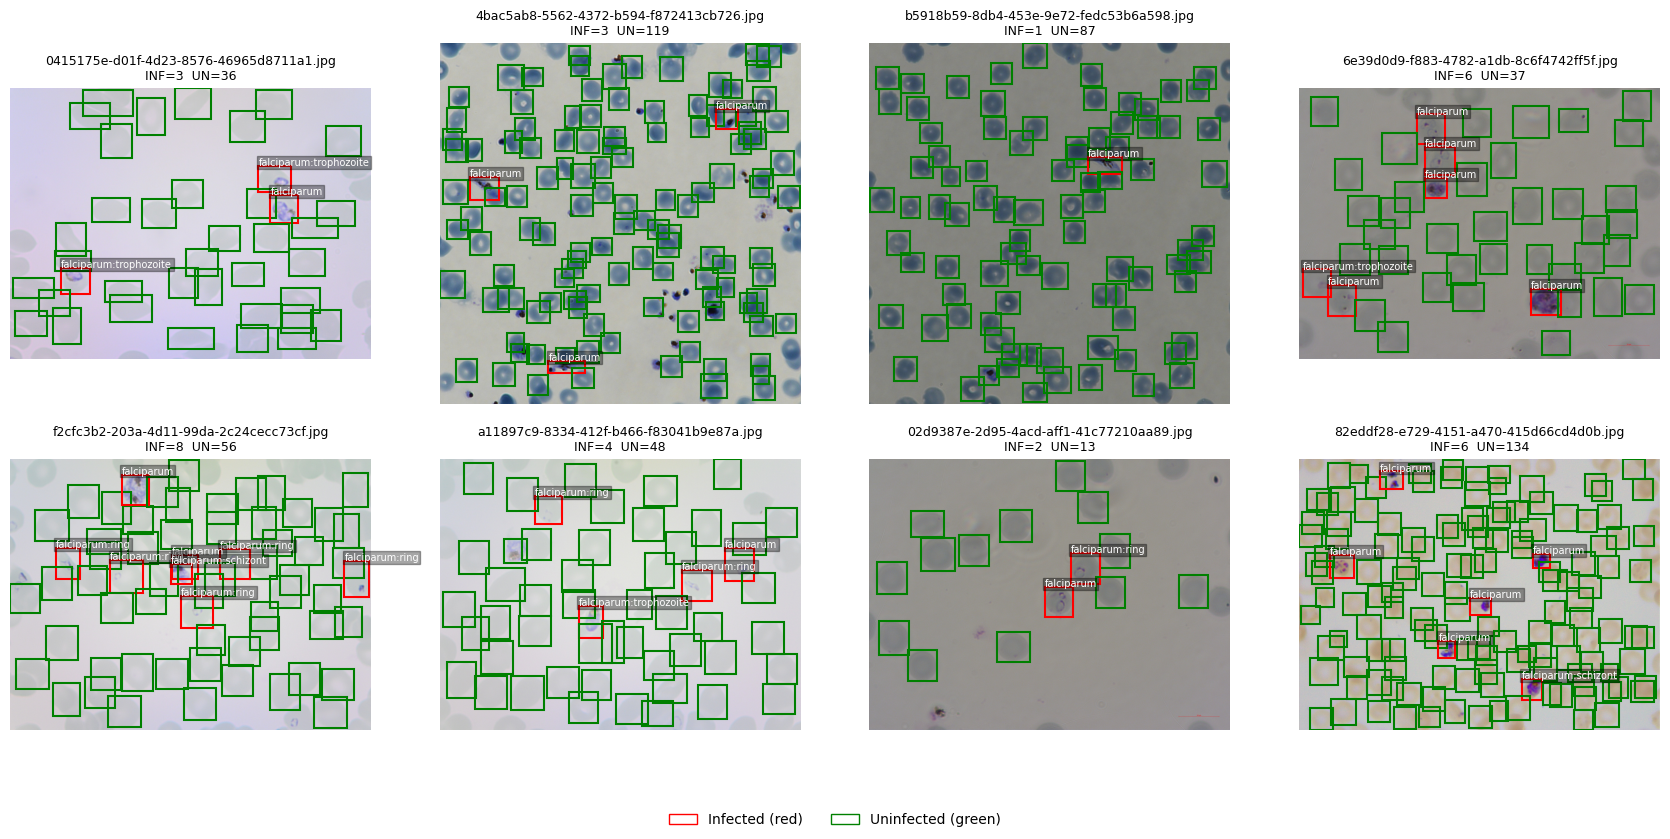

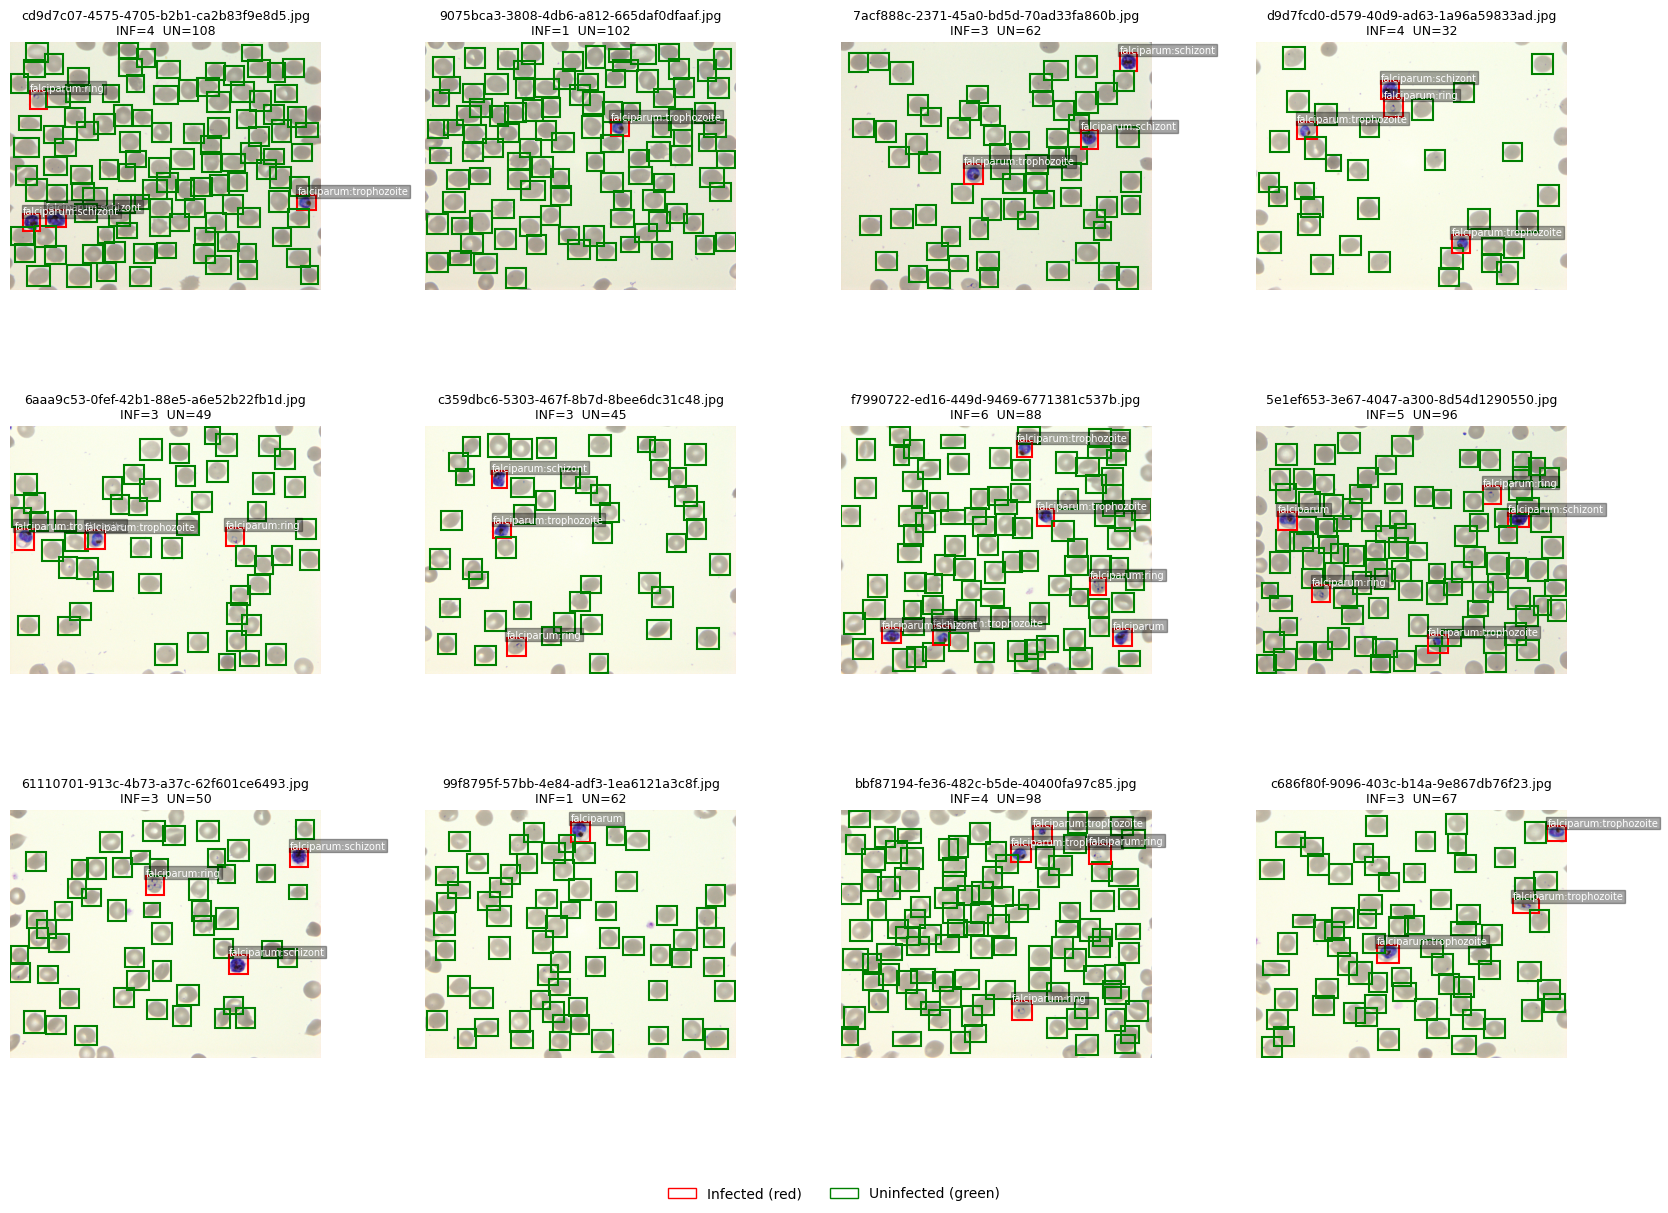

In [19]:
if not DRY_RUN:
    # Train grid
    show_examples_grid(COCO_train, SC_train, DST_DIR/"images/train", k=12, ncols=4, seed=1)

    # Val grid
    show_examples_grid(COCO_val, SC_val, DST_DIR/"images/val", k=8, ncols=4, seed=2)

    # Test grid
    show_examples_grid(COCO_test, SC_test, DST_DIR/"images/test", k=12, ncols=4, seed=3)
